In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_mf = pd.read_csv('mfdata.csv')
df_mf = df_mf[(df_mf['investment'] == 'Blend') | (df_mf['investment'] == 'Growth') | (df_mf['investment'] == 'Value')]
df_mf = df_mf[df_mf['portfolio_stocks'] > 90]
df_mf = df_mf[df_mf['fund_return_10years'] != 0]

s_rets = df_mf['fund_return_10years']
df_mf = df_mf[['net_assets', 'fund_yield', 'morningstar_rating','investment', 'size', 
               'net_annual_expense_ratio_fund','portfolio_stocks','price_earnings', 
               'basic_materials', 'consumer_cyclical','financial_services', 'real_estate', 'consumer_defensive', 
               'healthcare','utilities', 'communication_services', 'energy', 'industrials',
               'technology', 'morningstar_return_rating','fund_return_2018', 'fund_return_2017', 
               'fund_return_2016','fund_return_2015', 'fund_return_2014', 'fund_return_2013','fund_return_2012', 
               'fund_return_2011', 'fund_return_2010','morningstar_risk_rating', 'fund_alpha_3years',
               'fund_alpha_5years','fund_alpha_10years', 'fund_beta_3years', 'fund_beta_5years','fund_beta_10years', 
               'fund_r_squared_3years', 'fund_r_squared_5years','fund_r_squared_10years', 
               'fund_standard_deviation_3years','fund_standard_deviation_5years', 'fund_standard_deviation_10years',
               'fund_sharpe_ratio_3years', 'fund_sharpe_ratio_5years','fund_sharpe_ratio_10years']]

In [3]:
s_rets = s_rets > 13.6
s_rets = s_rets.astype(int)
sum(s_rets)/len(s_rets)

0.5453571428571429

In [4]:
investment_dummies = pd.get_dummies(df_mf['investment'],prefix="investment")
size_dummies = pd.get_dummies(df_mf['size'],prefix="size")

df_mf = pd.concat([df_mf,investment_dummies,size_dummies], axis=1)
df_mf = df_mf.drop(['investment','size'],axis=1)
df_mf

,net_assets,fund_yield,morningstar_rating,net_annual_expense_ratio_fund,portfolio_stocks,price_earnings,basic_materials,consumer_cyclical,financial_services,real_estate,...,fund_standard_deviation_10years,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_sharpe_ratio_10years,investment_Blend,investment_Growth,investment_Value,size_Large,size_Medium,size_Small
2,1.080000e+09,0.00,3,1.15,97.06,24.49,0.00,20.20,16.12,0.00,...,14.89,1.05,0.86,1.01,0,1,0,1,0,0
24,8.565000e+07,0.77,3,1.79,99.99,12.29,7.56,29.10,0.00,0.00,...,20.17,0.88,0.48,0.57,1,0,0,1,0,0
26,5.715000e+08,1.40,3,0.86,95.43,12.69,4.37,15.77,22.65,7.90,...,16.23,0.50,0.36,0.94,0,0,1,0,1,0
35,5.800000e+09,1.94,3,0.62,94.77,12.54,3.67,10.58,24.33,0.09,...,14.31,0.77,0.48,0.96,0,0,1,1,0,0
44,2.900000e+09,2.19,4,0.67,95.77,12.09,8.21,10.72,21.79,1.94,...,16.34,0.46,0.07,0.57,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25266,2.875000e+08,0.00,4,2.11,93.78,19.00,1.22,20.50,26.29,0.00,...,12.01,0.96,0.73,1.03,0,1,0,1,0,0
25267,2.875000e+08,0.21,5,1.09,93.78,19.00,1.22,20.50,26.29,0.00,...,12.00,1.06,0.83,1.11,0,1,0,1,0,0
25268,4.259000e+07,0.00,4,1.50,91.02,12.27,2.30,14.59,27.80,1.05,...,19.92,0.83,0.45,0.82,1,0,0,0,0,1
25269,4.259000e+07,0.00,3,2.00,91.02,12.27,2.30,14.59,27.80,1.05,...,19.90,0.80,0.42,0.80,1,0,0,0,0,1


In [26]:
k_values = [x for x in range(3,11)]
accuracy_test = []
accuracy_train = []

X_train, X_test, y_train, y_test = train_test_split(df_mf, s_rets, test_size=0.25, random_state=42)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

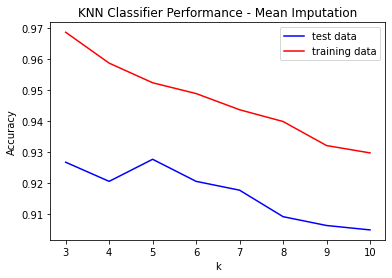

In [27]:
for val in k_values:
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.to_numpy())
    X_test_scaled = scaler.transform(X_test.to_numpy())
    
    knn = KNeighborsClassifier(n_neighbors = val,n_jobs=-1)
    knn.fit(X_train_scaled, y_train.to_numpy())
    
    acc_test = knn.score(X_test_scaled,y_test.to_numpy())
    accuracy_test.append(acc_test)
    
    acc_train = knn.score(X_train_scaled,y_train.to_numpy())
    accuracy_train.append(acc_train)
    
plt.plot(k_values,accuracy_test,color='blue',label='test data')
plt.plot(k_values,accuracy_train,color='red',label='training data')
plt.legend(loc="upper right")
plt.title('KNN Classifier Performance - Mean Imputation')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

In [28]:
accuracy_test = []
accuracy_train = []

df_mf2 = pd.concat([df_mf,s_rets],axis=1)
df_mf2 = df_mf2.dropna()

s_rets2 = df_mf2['fund_return_10years']
df_mf2 = df_mf2.drop('fund_return_10years',axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_mf2, s_rets2, test_size=0.25, random_state=42)


X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

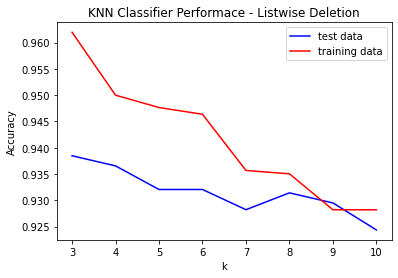

In [29]:
for val in k_values:
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.to_numpy())
    X_test_scaled = scaler.transform(X_test.to_numpy())
    
    knn = KNeighborsClassifier(n_neighbors = val,n_jobs=-1)
    knn.fit(X_train_scaled, y_train.to_numpy())
    
    acc_test = knn.score(X_test_scaled,y_test.to_numpy())
    accuracy_test.append(acc_test)
    
    acc_train = knn.score(X_train_scaled,y_train.to_numpy())
    accuracy_train.append(acc_train)
    
plt.plot(k_values,accuracy_test,color='blue',label='test data')
plt.plot(k_values,accuracy_train,color='red',label='training data')
plt.legend(loc="upper right")
plt.title('KNN Classifier Performace - Listwise Deletion')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()